## Import libraries and data 

In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
# Keras to build the model
import keras
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import Input, Dense, Concatenate
from keras.layers.core import Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import pyplot


# Pickle to load the data and save the models
import pickle

In [40]:
# shape 64,64 must be the same with the input of the NN

def preprosses_image(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [44]:
category_list = ['Tops', 'Bottoms', 'Bags', 'Shoes', 'Onepieces', 'Outwear', 'Accessories']

In [45]:
#function to import images, preproccess the and save them to a pickle file.
for i in category_list:
    image_dir_path = f"/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/{i}/*.*"
    pickle_path = f"/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/pickle_files/polyvore_1000_cleaned/{i}.pkl"
    img_paths = glob.glob(image_dir_path)
    print(img_paths)
    preprocessed_images = [preprosses_image(path) for path in img_paths]
    features = np.array(preprocessed_images)
    print(features.shape)
    with open(pickle_path, "wb") as pickle_file:
        pickle.dump(features, pickle_file)
    
    


['/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216952063_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216846736_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216885092_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216733276_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216676103_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216619355_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216974703_1.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216947371_2.jpg', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/Tops/216855346_2.jpg', '/home/thanos/Desktop/Sustainable_fashion/dat

In [5]:
with open("/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/pickle_files/polyvore_1000_cleaned/Bags", "rb") as f:
    loaded_images = pickle.load(f)

In [6]:
type(loaded_images)

numpy.ndarray

In [3]:
# Initialize the imput as a color image size 64x64 pixels
input_layer = Input(shape=(64,64,3))

# Encoder: Increase dimensionality in convolutions, then reduce to 16x1x1
conv1 = Conv2D(496, (3, 3), activation='relu', padding='same')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
conv2 = Conv2D(248, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
conv3 = Conv2D(124, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool4)
pool5 = MaxPooling2D((2, 2), padding='same')(conv5)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool5)
pool6 = MaxPooling2D((2, 2), padding='same')(conv6)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool6)
pool7 = MaxPooling2D((2, 2), padding='same')(conv7)

# Reduced dimensionailty layer that can be taken as an embedding of the original image
encoded = Flatten(name = 'encoded')(pool7)

# Decoder: Reverse the process of the encoder
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool7) 
up1 = UpSampling2D((2,2))(conv8)
conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) 
up2 = UpSampling2D((2,2))(conv9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) 
up3 = UpSampling2D((2,2))(conv10) 
conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
up4 = UpSampling2D((2,2))(conv11)
conv12 = Conv2D(124, (3, 3), activation='relu', padding='same')(up4)
up5 = UpSampling2D((2,2))(conv12) 
conv13 = Conv2D(248, (3, 3), activation='relu', padding='same')(up5)
up6 = UpSampling2D((1, 1))(conv13)
conv14 = Conv2D(496, (3, 3), activation='relu', padding='same')(up6)
up7 = UpSampling2D((2, 2))(conv14)

# Final layer that is the same shape as the input. This is the result that should return the same image as the input
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(up7)
# Check the output is the same shape as the input
print ('shape of decoded', K.int_shape(decoded))

# Initialize input and output
autoencoder = Model(input_layer, decoded)

# Model that will return the embedding rather than the predicted image, but trained using the autoencoded model
encoder = Model(input_layer, encoded)
# Plotting the model if we want
#plot_model(autoencoder,show_shapes=True)

shape of decoded (None, 64, 64, 3)


In [42]:
json_autoencoder = autoencoder.to_json()
json_encoder = encoder.to_json()

In [19]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(loaded_images, loaded_images, epochs=50, batch_size=32, shuffle=True)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/50
31/31 [==============================] - 8s 228ms/step - loss: 0.0514
Epoch 2/50
31/31 [==============================] - 7s 228ms/step - loss: 0.0376
Epoch 3/50
31/31 [==============================] - 7s 229ms/step - loss: 0.0355
Epoch 4/50
31/31 [==============================] - 7s 230ms/step - loss: 0.0356
Epoch 5/50
31/31 [==============================] - 7s 230ms/step - loss: 0.0346
Epoch 6/50
31/31 [==============================] - 7s 231ms/step - loss: 0.0349
Epoch 7/50
31/31 [==============================] - 7s 231ms/step - loss: 0.0346
Epoch 8/50
31/31 [==============================] - 7s 232ms/step - loss: 0.0345
Epoch 9/50
31/31 [==============================] - 7s 231ms/step - loss: 0.0343
Epoch 10/50
31/31 [==============================] - 7s 231ms/step - loss: 0.0342
Epoch 11/50
31/31 [==============================] - 7s 231ms/step - loss: 0.0336
Epoch 12/50
31/31 [==============================] - 7s 232ms/step - loss: 0.0333
Epoch 13/50
31/31 [======

In [20]:
autoencoder.save('autoencoder_model_bags_v1.h5')
loaded_autoencoder = load_model('autoencoder_model.h5')


1/1 [==============================] - 0s 184ms/step


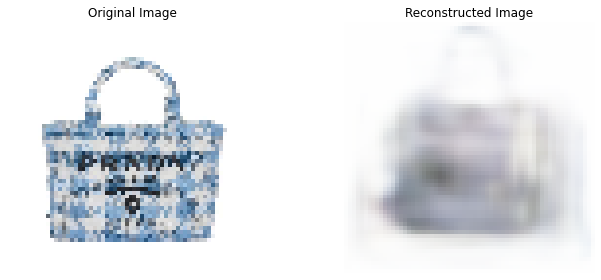

In [25]:
def preprocess_image(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

image_path = '/home/thanos/Desktop/Sustainable_fashion/data/test_images/result_image_1688505367634.jpg'  # Replace with your image path
original_image = preprocess_image(image_path)

# Add a new axis to make it a batch of size 1
original_image_batch = np.expand_dims(original_image, axis=0)

# Get the autoencoder's reconstruction
reconstructed_image = autoencoder.predict(original_image_batch)

# Display the original and reconstructed images using matplotlib
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0])
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
image_path = '/home/thanos/Desktop/Sustainable_fashion/data/test_images/result_image_1688505367634.jpg'  
img_np = cv2.imread(image_path, cv2.IMREAD_COLOR)
# Resize the image
img_resized = cv2.resize(img_np, (64, 64))
# Scale the image
img_scaled = img_resized / 255.0



img_input = np.expand_dims(img_scaled, axis=0)
encoded_representation = encoder.predict(img_input)

1/1 [==============================] - 0s 112ms/step


In [32]:
encoded_representation.shape

(1, 16)

In [2]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
item = ['Tops', 'Bottoms', 'Bags', 'Shoes', 'Onepieces', 'Outwear', 'Accessories']

for i in range(0,len(item)):
    # Establish the models from the jsons
    autoencoder = model_from_json(json_autoencoder)
    encoder = model_from_json(json_encoder)
    
    # Import the images (which are preprocessed and stored in a numpy array of shape (15049,3,64,64))
    path = '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/pickle_files/polyvore_1000_cleaned/' + item[i] + '.pkl'
    with open(path, 'rb') as picklefile: 
        features = pickle.load(picklefile)
    # Standardize the features
    #features = features/255
    
    # Fit the Model
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    print('Fitting model '+str(i+1))
    autoencoder.fit(features, features, epochs=400, batch_size=100, validation_split=.15, callbacks=[early_stopping])
    
    # Save the model and and encoder
    autoencoder_name = item[i] + '_model.h5'
    autoencoder.save(autoencoder_name)
    encoder_name = item[i] + 'embedding_model.h5'
    encoder.save(encoder_name)
    
    # Delete the images and models to make room in memory
    del(features)
    del(autoencoder)
    del(encoder)

In [4]:
with open("/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/pickle_files/polyvore_1000_cleaned/Bags.pkl", "rb") as f:
    loaded_images = pickle.load(f)

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(loaded_images, loaded_images, epochs=400, batch_size=100, validation_split=.15, callbacks=[early_stopping])